Solved Exercise

['D:\\Datasets\\cats_and_dogs_filtered\\train\\cats', 'D:\\Datasets\\cats_and_dogs_filtered\\train\\dogs']
<PIL.Image.Image image mode=RGB size=500x374 at 0x15068D0AE50>


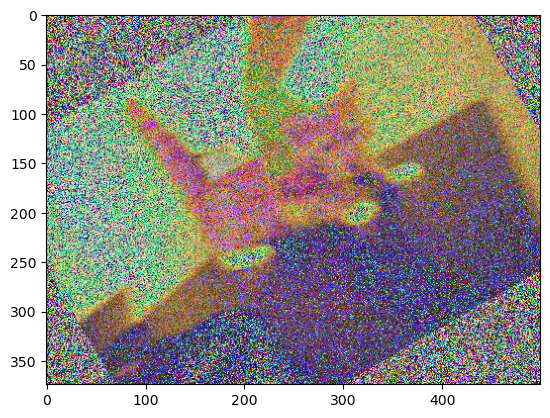

<PIL.Image.Image image mode=RGB size=300x280 at 0x150678213D0>


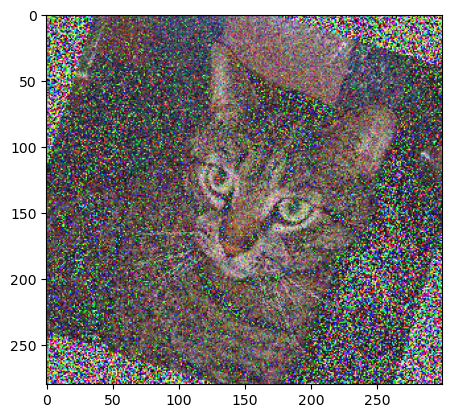

<PIL.Image.Image image mode=RGB size=489x499 at 0x1506AEDB490>


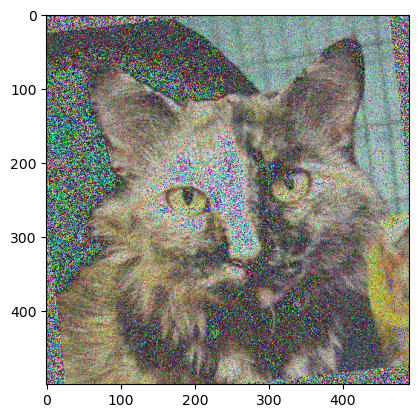

In [19]:
import PIL
import torch
import torchvision.transforms as T
from PIL import Image
import glob
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2

img = Image.open('coins.jpg')

class Gaussian(object):
    def __init__(self,mean:float,var:float):
        self.mean = mean
        self.var = var
    
    def __call__(self,img:torch.Tensor) -> torch.Tensor:
        return img + torch.normal(self.mean,self.var,img.size())
    
preprocess = T.Compose([
    T.ToTensor(),T.RandomHorizontalFlip(),T.RandomRotation(45),Gaussian(0,0.15)
])

class MyDataset(Dataset):
    def __init__(self,transform=None,string="train"):
        self.imgs_path = "D:\\Datasets\\cats_and_dogs_filtered\\" + string + "\\"
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path + "\\*.jpg"):
                self.data.append([img_path,class_name])
        self.class_map = {"dogs":0,"cats":1}
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img_path,class_name = self.data[idx]
        img = PIL.Image.open(img_path)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)
        if self.transform:
            img = self.transform(img)
        return img,class_id 
    
dataset = MyDataset(transform=preprocess,string="train")
dataloader = DataLoader(dataset)

i=0
for data in iter(dataloader):
    img,_ = data
    tI = T.ToPILImage()
    img = tI(img.squeeze())
    plt.imshow(img)
    print(img)
    plt.show()
    i = i+1
    if i==3:
        break

Q4. nn.Dropout vs Custom Dropout

In [16]:
import PIL.Image as Image
import pandas as pd
import glob
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset,DataLoader
from torchvision.models import AlexNet_Weights
from torchvision import transforms as T
import matplotlib.pyplot as plt

epochs = 10
batch_size_train = 16
batch_size_test = 100
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = T.Compose([
    T.ToTensor(),
    T.Resize([224,224]),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
classes = {'dogs':0,'cats':1}
lib_dropout = {'train':[],'test':[]}
custom_dropout = {'train':[],'test':[]}

class MyDataset(Dataset):
    def __init__(self,transform=None,string="train"):
        self.imgs_path = "D:\\Datasets\\cats_and_dogs_filtered\\" + string + "\\"
        print(self.imgs_path)
        file_list = glob.glob(self.imgs_path+"*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path+"\\*.jpg"):
                self.data.append([img_path,class_name])
        self.class_map = {'dogs':1,'cats':0}
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img_path,class_name = self.data[idx]
        img = Image.open(img_path)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)
        if self.transform:
            img = self.transform(img)
        return img,class_id
    
def model_lib_dropout(dropout = 0.5):
    model = torch.hub.load("pytorch/vision:v0.10.0",'alexnet',weights=AlexNet_Weights.DEFAULT)
    model.features.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(256*6*6,4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout),
        nn.Linear(4096,4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096,2)
    )
    return model

class CustomDropout(nn.Module):
    def __init__(self,p):
        super().__init__()
        self.p = p
        
    def forward(self,x):
        if self.training:
            mask = torch.empty_like(x).bernoulli_(1-self.p)
            return x * mask / (1-self.p)
        else:
            return x

def model_custom_dropout(dropout=0.5):
    model = torch.hub.load('pytorch/vision:v0.10.0','alexnet',weights=AlexNet_Weights.DEFAULT)
    model.features.requires_grad=False     
    model.classifier = nn.Sequential(
        CustomDropout(p=dropout),
        nn.Linear(9216,4096),
        nn.ReLU(inplace=True),
        CustomDropout(p=dropout),
        nn.Linear(4096,4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096,2),
    )
    return model

def train(model, train_loader, criterion, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    running_loss /= len(train_loader.dataset)
    acc = 100. * correct / len(train_loader.dataset)
    return acc, running_loss

def test(model, test_loader, criterion, device="cpu"):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            running_loss += criterion(output, target).item() * len(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    running_loss /= len(test_loader)
    acc = 100. * correct / len(test_loader)
    return acc, running_loss

trainset = MyDataset(transform,"train")
testset = MyDataset(transform,"validation")
train_loader = DataLoader(trainset,batch_size_train,shuffle=True)
test_loader = DataLoader(testset,batch_size_test,shuffle=True)

criterion = nn.CrossEntropyLoss()
model1 = model_lib_dropout()
model1 = model1.to(device)
optimizer1 = optim.SGD(model1.parameters(),lr=lr)
model2 = model_custom_dropout()
model2.to(device)
optimizer2 = optim.SGD(model2.parameters(),lr=lr)

for epoch in range(1,epochs + 1):
    print("Epoch",epoch)
    train_acc,train_loss = train(model1,train_loader,criterion,optimizer1,device)
    print("\tTraining Accuracy:",train_acc)
    print("\tTraining Loss:",train_loss)
    test_acc,test_loss = test(model1,test_loader,criterion,device)
    print("\tTesting Accuracy:",test_acc)
    print("\tTesting Loss:",test_loss)

print("\n\nUsing custom dropout:")    

for epoch in range(1,epochs + 1):
    print("Epoch",epoch+1)
    train_acc,train_loss = train(model2,train_loader,criterion,optimizer2,device)
    print("\tTraining Accuracy:",train_acc)
    print("\tTraining Loss:",train_loss)
    test_acc,test_loss = test(model2,test_loader,criterion,device)
    print("\tTesting Accuracy:",test_acc)
    print("\tTesting Loss:",test_loss)

D:\Datasets\cats_and_dogs_filtered\train\
['D:\\Datasets\\cats_and_dogs_filtered\\train\\cats', 'D:\\Datasets\\cats_and_dogs_filtered\\train\\dogs']
D:\Datasets\cats_and_dogs_filtered\validation\
['D:\\Datasets\\cats_and_dogs_filtered\\validation\\cats', 'D:\\Datasets\\cats_and_dogs_filtered\\validation\\dogs']


Using cache found in C:\Users\sreya/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\sreya/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 1
	Training Accuracy: tensor(80.0500)
	Training Loss: 0.4391739577054977
	Testing Accuracy: tensor(9360.)
	Testing Loss: 23.067075610160828
Epoch 2
	Training Accuracy: tensor(92.4000)
	Training Loss: 0.2210842776596546
	Testing Accuracy: tensor(9430.)
	Testing Loss: 14.982443377375603
Epoch 3
	Training Accuracy: tensor(94.1500)
	Training Loss: 0.15763079854846002
	Testing Accuracy: tensor(9450.)
	Testing Loss: 13.55357751250267
Epoch 4
	Training Accuracy: tensor(94.6500)
	Training Loss: 0.1363007077127695
	Testing Accuracy: tensor(9500.)
	Testing Loss: 12.368525490164757
Epoch 5
	Training Accuracy: tensor(95.9500)
	Training Loss: 0.11364684578031302
	Testing Accuracy: tensor(9570.)
	Testing Loss: 10.180155299603939
Epoch 6
	Training Accuracy: tensor(96.4000)
	Training Loss: 0.10331409472972154
	Testing Accuracy: tensor(9550.)
	Testing Loss: 10.185225550085306
Epoch 7
	Training Accuracy: tensor(96.6500)
	Training Loss: 0.09101545690186322
	Testing Accuracy: tensor(9470.)
	Testing 

In [21]:
import PIL.Image as Image
import pandas as pd
import glob
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset,DataLoader
from torchvision.models import AlexNet_Weights
from torchvision import transforms as T
import matplotlib.pyplot as plt

epochs = 10
batch_size_train = 16
batch_size_test = 100
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = T.Compose([
    T.ToTensor(),
    T.Resize([224,224]),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
classes = {'dogs':0,'cats':1}
lib_dropout = {'train':[],'test':[]}
custom_dropout = {'train':[],'test':[]}

class MyDataset(Dataset):
    def __init__(self,transform=None,string="train"):
        self.imgs_path = "D:\\Datasets\\cats_and_dogs_filtered\\" + string + "\\"
        print(self.imgs_path)
        file_list = glob.glob(self.imgs_path+"*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path+"\\*.jpg"):
                self.data.append([img_path,class_name])
        self.class_map = {'dogs':1,'cats':0}
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img_path,class_name = self.data[idx]
        img = Image.open(img_path)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)
        if self.transform:
            img = self.transform(img)
        return img,class_id
    
def get_model():
    model = torch.hub.load('pytorch/vision:v0.10.0','alexnet',weights=AlexNet_Weights.DEFAULT)
    model.features.requires_grad=False
    model.classifier = nn.Sequential(
        *model.classifier[:-1],
        nn.Linear(4096,2,bias=True))
    return model

def train(model,train_loader,criterion,optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    for batch_idx,(inputs,targets) in enumerate(train_loader):
        inputs,targets = inputs.to(device),targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(inputs)
        pred = outputs.data.max(1,keepdim=True)[1]
        correct += pred.eq(targets.data.view_as(pred)).sum()
    running_loss /= len(train_loader)
    acc = 100. * correct / len(train_loader)
    return acc, running_loss

def test(model, test_loader, criterion, device="cpu"):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            running_loss += criterion(output, target).item() * len(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    running_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    return acc, running_loss

model = get_model()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

patience = 5
best_validation_loss = float('inf')
current_patience = 0
for epoch in range(1,epochs+1):
    print(f"Epoch: {epoch}")
    train_acc, train_loss = train(model, train_loader, criterion, optimizer, device)
    print("\tTraining Accuracy: {:.4}%".format(train_acc))
    print("\tTraining Loss: {:.4}".format(train_loss))

    print("\tValidation: ")
    test_acc, test_loss = test(model, test_loader, criterion, device)
    print("\tTesting Accuracy: {:.4}%".format(test_acc))
    print("\tTesting Loss: {:.4}".format(test_loss))
    
    # Check for improvement in validation loss
    if test_loss < best_validation_loss:
        best_validation_loss = test_loss
        current_patience = 0
    else:
        current_patience += 1
    # Check if early stopping criteria are met
    if current_patience > patience:
        print("Early stopping! No improvement for {} epochs.".format(patience))
        break


Using cache found in C:\Users\sreya/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch: 1
	Training Accuracy: 823.2%
	Training Loss: 12.83
	Validation: 
	Testing Accuracy: 50.0%
	Testing Loss: 0.6963
Epoch: 2
	Training Accuracy: 808.0%
	Training Loss: 11.12
	Validation: 
	Testing Accuracy: 50.0%
	Testing Loss: 0.6933
Epoch: 3
	Training Accuracy: 797.6%
	Training Loss: 11.11
	Validation: 
	Testing Accuracy: 50.0%
	Testing Loss: 0.6934
Epoch: 4
	Training Accuracy: 789.6%
	Training Loss: 11.1
	Validation: 
	Testing Accuracy: 50.0%
	Testing Loss: 0.6932
Epoch: 5
	Training Accuracy: 821.6%
	Training Loss: 11.13
	Validation: 
	Testing Accuracy: 50.0%
	Testing Loss: 0.6932
Epoch: 6
	Training Accuracy: 792.0%
	Training Loss: 11.13
	Validation: 
	Testing Accuracy: 50.0%
	Testing Loss: 0.6944
Epoch: 7
	Training Accuracy: 820.8%
	Training Loss: 11.13
	Validation: 
	Testing Accuracy: 50.0%
	Testing Loss: 0.6932
Epoch: 8
	Training Accuracy: 776.8%
	Training Loss: 11.1
	Validation: 
	Testing Accuracy: 50.0%
	Testing Loss: 0.6939
Epoch: 9
	Training Accuracy: 796.0%
	Training Loss